In [11]:
import torch
import random
import numpy as np
import torchvision.transforms as transforms
from torchvision.datasets import USPS
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn

In [2]:
# Установка сидов для воспроизводимости
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
# Преобразования изображений
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Нормализация значений пикселей в диапазон [-1, 1]
])

In [5]:
# Загрузка датасета USPS
train = USPS(root='./data', train=True, transform=transform, download=True)
test = USPS(root='./data', train=False, transform=transform, download=True)

# Создание загрузчиков
train_loader = DataLoader(train, batch_size=32, shuffle=True) # перемешиваем данные в обучающем наборе
test_loader = DataLoader(test, batch_size=32, shuffle=False)  # без перемеивания в тестовом наборе

# Проверка структуры данных
for images, labels in train_loader:
    print(f'Batch size: {images.shape}')
    print(f'Labels: {labels.shape}')
    break

Batch size: torch.Size([32, 1, 96, 96])
Labels: torch.Size([32])


In [7]:
# Сопоставление классов USPS (цифры 0-9)
classes = [str(i) for i in range(10)]
classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [25]:
# Формируем x_train и y_train
x_train, y_train = [], []
for images, labels in train_loader:
    x_train.append(images) # добавляем изображения
    y_train.append(labels) # добавляем метки

x_train = torch.cat(x_train) # объединяем список изображений в один тензор
y_train = torch.cat(y_train) # объединяем список меток в один тензор

In [34]:
y_train


tensor([4, 3, 7,  ..., 4, 5, 9])

In [27]:
# Формируем x_test и y_test
x_test, y_test = [], []
for images, labels in test_loader:
    x_test.append(images)
    y_test.append(labels)

x_test = torch.cat(x_test)
y_test = torch.cat(y_test)

In [29]:
# Вывод размеров массивов
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: torch.Size([7291, 1, 96, 96])
y_train shape: torch.Size([7291])
x_test shape: torch.Size([2007, 1, 96, 96])
y_test shape: torch.Size([2007])


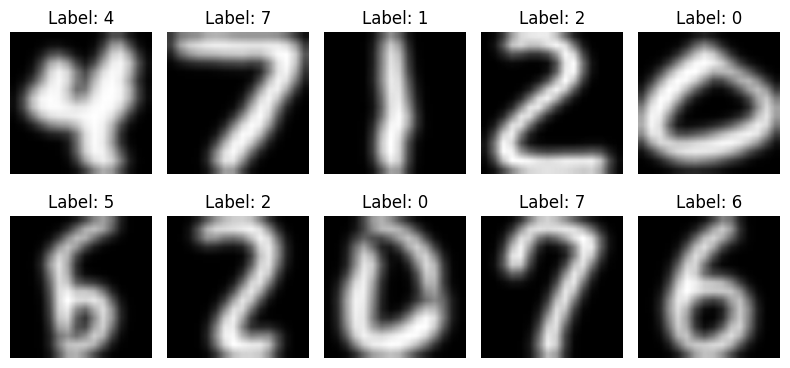

In [23]:
# Визуализация примеров изображений USPS
sample_size = 10
plt.figure(figsize=(8, 4))
# Генерируем случайные индексы
indices = np.random.permutation(x_train.shape[0])[:sample_size]

for count, i in enumerate(indices):
    plt.subplot(2, 5, count + 1)
    img = (x_train[i] + 1) / 2
    plt.imshow(img.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.title(f'Label: {classes[y_train[i].item()]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
# Определение сверточного блока с остаточным соединением
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)  # Сверточный слой 3x3
        self.act1 = nn.ReLU()  # Функция активации
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)  # Второй сверточный слой
        self.act2 = nn.ReLU()  # Функция активации

        # Добавляем shortcut соединение, если количество каналов меняется
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        residual = x if self.shortcut is None else self.shortcut(x)  # Shortcut-путь
        out = self.act1(self.conv1(x))  # Применение первого слоя и активации
        out = self.conv2(out)  # Применение второго слоя
        out += residual  # Добавляем остаточное соединение
        return self.act2(out)  # Применяем активацию

# Определение сверточной нейросети с остаточными блоками
class ResidualModel(nn.Module):
    def __init__(self):
        super(ResidualModel, self).__init__()
        self.layer1 = ResidualBlock(1, 16)  # Первый остаточный блок (вход 1 канал, выход 16 каналов)
        self.layer2 = ResidualBlock(16, 32)  # Второй остаточный блок
        self.pool = nn.AvgPool2d(2, 2)  # Средний пулинг для уменьшения размерности
        self.fc1 = nn.Linear(32 * 24 * 24, 120)  # Полносвязный слой
        self.fc2 = nn.Linear(120, 10)  # Выходной слой (10 классов)

    def forward(self, x):
        x = self.pool(self.layer1(x))  # Первый остаточный блок + пулинг
        x = self.pool(self.layer2(x))  # Второй остаточный блок + пулинг
        x = x.view(x.size(0), -1)  # Разворачивание в вектор
        x = self.fc1(x)  # Полносвязный слой
        return self.fc2(x)  # Выход

In [38]:
# Подготовка к обучению
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResidualModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Оптимизатор

In [39]:
# Обучение модели
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) # Отправляем данные на устройство
        optimizer.zero_grad()
        loss = loss_fn(model(images), labels) # Вычисляем функцию потерь
        loss.backward() # Обратное распространение ошибки
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_loss = sum(loss_fn(model(images.to(device)), labels.to(device)).item() for images, labels in test_loader)

    print(f'Epoch [{epoch + 1}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

Epoch [1], Train Loss: 0.0225, Val Loss: 22.7634
Epoch [2], Train Loss: 0.4615, Val Loss: 25.8058
Epoch [3], Train Loss: 0.2598, Val Loss: 22.3127
Epoch [4], Train Loss: 0.1610, Val Loss: 21.6855
Epoch [5], Train Loss: 0.0038, Val Loss: 26.3705
Epoch [6], Train Loss: 0.0726, Val Loss: 24.2716
Epoch [7], Train Loss: 0.0079, Val Loss: 28.1009
Epoch [8], Train Loss: 0.0887, Val Loss: 28.2767
Epoch [9], Train Loss: 0.0012, Val Loss: 24.3870
Epoch [10], Train Loss: 0.0006, Val Loss: 33.5393


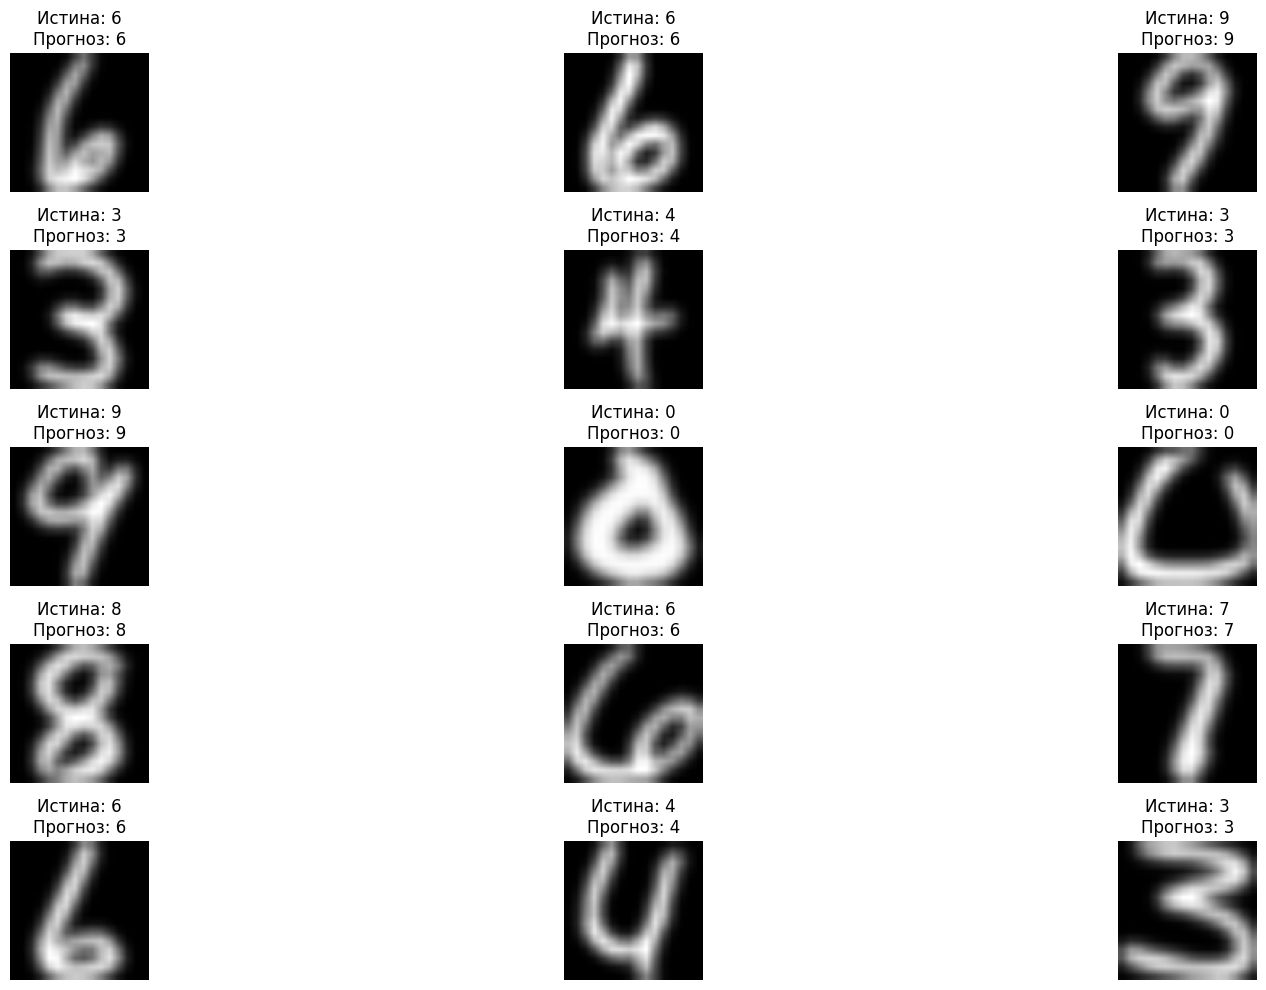

In [42]:
# Визуализация результатов
def show_results(model, x_test, y_test, h=5, w=3):
    with torch.no_grad():
        indices = torch.randint(0, x_test.shape[0], (h * w,))
        batch_probs = model(x_test[indices].to(device)).softmax(dim=1)

        fig, ax = plt.subplots(h, w, figsize=(20, 10))
        for i in range(h * w):
            plt.subplot(h, w, i + 1)
            img = (x_test[indices[i]].cpu() + 1) / 2
            plt.imshow(img.permute(1, 2, 0).squeeze(), cmap='gray')

            pred = torch.argmax(batch_probs[i])
            title = f'Истина: {classes[y_test[indices[i]].item()]}\nПрогноз: {classes[pred.item()]}'
            plt.title(title, fontsize=12)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

show_results(model, x_test, y_test)